In [43]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/obs_per_sec.npy", recursive=True)
obs_per_sec = np.array([np.load(p)[0] for p in paths])
obs_per_sec

array([14.831368, 14.821361, 14.496514, 15.546344, 17.160868, 14.614235,
       15.771565, 15.128821, 15.571923, 16.1113  , 14.863662, 15.268391],
      dtype=float32)

In [45]:
chunks_range = range(SEQ_LEN-1, 1160, SEQ_LEN)

In [46]:
run_paths = glob.glob("/home/beans/blender_membank/*/run*", recursive=True)

In [47]:
run_path = random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in chunks_range], axis=0)
maps = np.concatenate([np.load(f'{run_path}/maps_{i}.npy') for i in chunks_range], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct
#maps[:-1,:,:,:] = maps[1:,:,:,:]

targets_all = targets
targets, wp_dists, wp_z = np.split(targets_all, 3, axis=1)

aux.shape, targets.shape, wp_dists.shape, wp_z.shape, maps.shape, run_path

((1160, 5),
 (1160, 30),
 (1160, 30),
 (1160, 30),
 (1160, 100, 80, 3),
 '/home/beans/blender_membank/dataloader_04/run_9')

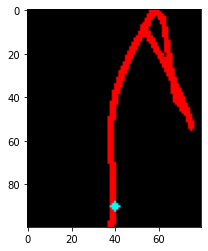

In [48]:
plt.imshow(maps[550])

In [49]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

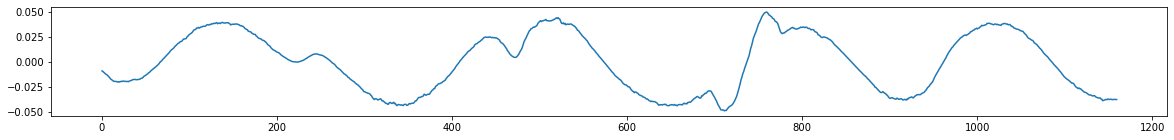

In [50]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

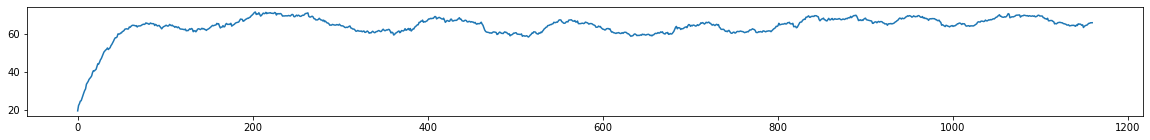

In [51]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [52]:
ix = 1000

In [53]:
t = smooth_near_wps(targets[ix])

In [54]:
xs_smoothed = np.sin(t) * wp_dists[ix]
ys_smoothed = np.cos(t) * wp_dists[ix]

xs = np.sin(targets[ix]) * wp_dists[ix]
ys = np.cos(targets[ix]) * wp_dists[ix]

In [55]:
headings_smoothed = get_headings_from_traj(t, wp_dists[ix])
headings = get_headings_from_traj(targets[ix], wp_dists[ix])

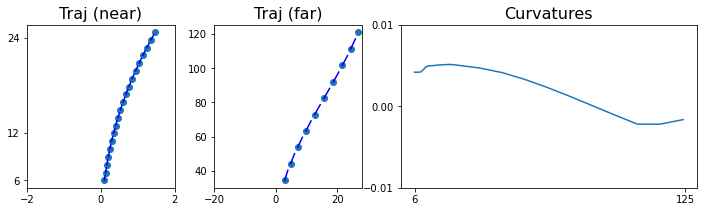

In [56]:
fig = get_pts_and_headings_fig(t, wp_dists[ix], headings_smoothed, get_curvatures_from_headings(smooth_near_wps(headings_smoothed)))

<BarContainer object of 10 artists>

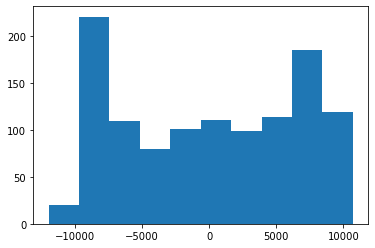

In [57]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

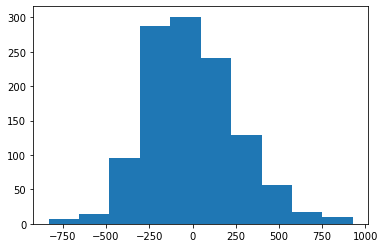

In [58]:
plt.hist(torque[1:]-torque[:-1])[2]

In [59]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [60]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    img[:,-80:,:] = np.fliplr(maps[i])
    
    video.write(img)
    
video.release()

In [61]:
from viz_utils import make_vid

imgs = np.stack([cv2.imread(f)[:,:,::-1] for f in img_paths]).astype(np.uint8)

for i in range(len(imgs)):
    imgs[i,:,-80:,:] = np.fliplr(maps[i])

aux_vid = aux.copy()
#aux_vid[:,:2] = 0 # zeroing out pitch and yaw

run_id = "sim"
model_stem = "8.22_avg"
rollout_data = make_vid(run_id, model_stem, imgs, aux_vid, targets=targets, add_charts=False)

(1160, 30) (1160, 1, 13, 80) (1160, 1, 13, 80)
Made vid!


In [19]:
combine_vids("8.9_avg", "8.9_avgTrain", "sim")

combined!


In [267]:
#p = get_viz_rollout(model_stem, imgs, aux_vid, do_gradcam=False)
#wp_angles_all, wp_headings_all, wp_curvatures_all, _, _, _, _, _ = p

In [23]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = rollout_data

(array([ 165.,  323.,  368.,  670.,  868., 1164., 1025.,  626.,  446.,
         145.]),
 array([-0.06666353, -0.05459857, -0.04253361, -0.03046865, -0.01840369,
        -0.00633873,  0.00572622,  0.01779118,  0.02985614,  0.0419211 ,
         0.05398606], dtype=float32),
 <BarContainer object of 10 artists>)

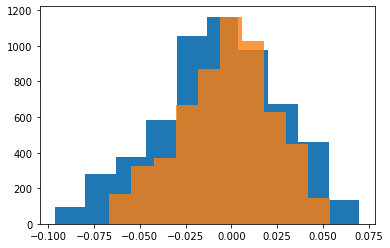

In [24]:
plt.hist(targets[:,:5].flatten())
plt.hist(wp_angles_all[:,:5].flatten(), alpha=.8)

(array([ 79., 325., 488., 731., 949., 890., 794., 910., 536.,  98.]),
 array([-0.09078395, -0.07428899, -0.05779405, -0.0412991 , -0.02480415,
        -0.0083092 ,  0.00818575,  0.0246807 ,  0.04117565,  0.0576706 ,
         0.07416555], dtype=float32),
 <BarContainer object of 10 artists>)

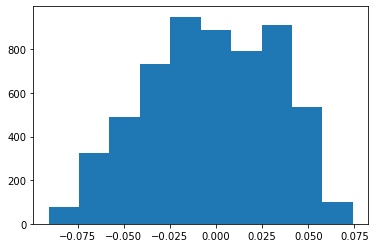

In [162]:
obsnet_outs.shape

(1160, 3)

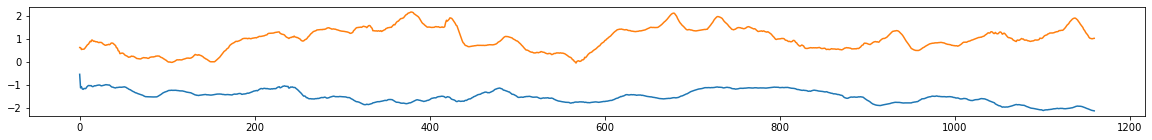

In [163]:
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,1])
plt.plot(obsnet_outs[:,2])

In [164]:
aux[0]

array([-1.5071025e+00,  6.1787933e-01,  3.4964561e+01,  0.0000000e+00,
       -3.0346576e-03], dtype=float32)

In [62]:
all_aux = []
all_wp_angles = []
all_wp_dists = []
all_run_paths = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/home/beans/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in chunks_range]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        wp_angles, wp_dists, wp_zs = np.split(targets, 3, axis=1)
        
        all_aux.append(aux)
        all_wp_angles.append(wp_angles)
        all_wp_dists.append(wp_dists)
        all_run_paths.append(run_path)
        
all_aux = np.stack(all_aux, axis=0)
all_wp_angles = np.stack(all_wp_angles, axis=0)
all_wp_dists = np.stack(all_wp_dists, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 12 out of 360 runs


In [21]:
%%time
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)

CPU times: user 2.58 s, sys: 7.78 ms, total: 2.59 s
Wall time: 2.59 s


In [22]:
all_curvatures = get_curvatures_from_headings_batch(all_headings)

In [23]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape

((137, 1160, 30), (137, 1160, 30), (137, 1160, 30), (137, 1160, 30))

In [24]:
mm = 0
for i in range(len(all_curvatures)):
    m = abs(all_curvatures[i]).max()
    if m > .05:
        print(i, m)
        mm += 1

12 0.05857727
40 0.053862065
72 0.054897368
105 0.058659747
136 0.069630116


In [25]:
all_run_paths[46]

'/home/beans/blender_membank/dataloader_04/run_1'

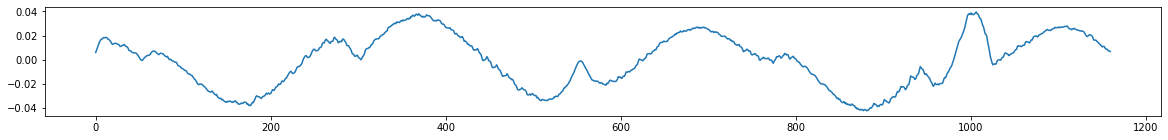

In [26]:
plt.figure(figsize=(20,2))
plt.plot(all_wp_angles[94,:,0])

<BarContainer object of 40 artists>

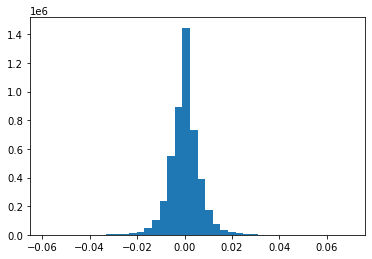

In [27]:
plt.hist(all_curvatures[:,:,:].flatten(), bins=40)[2]

In [28]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_wp_angles[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

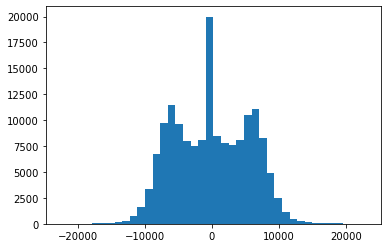

In [29]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

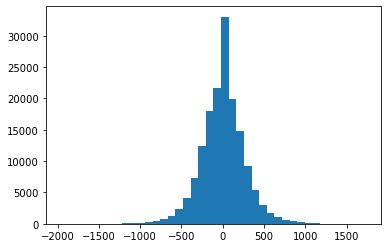

In [30]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [31]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(1253.6568656240513, 17534.96406960631)

In [32]:
mean_dists = abs(all_wp_dists).mean(axis=0).mean(0)
mean_dists

array([  5.9959874,   6.995128 ,   7.994211 ,   8.993207 ,   9.992137 ,
        10.99096  ,  11.989686 ,  12.988287 ,  13.986764 ,  14.985107 ,
        15.9832945,  16.981352 ,  17.97924  ,  18.97694  ,  19.974466 ,
        20.971811 ,  21.968935 ,  22.965889 ,  23.962637 ,  24.959152 ,
        34.91125  ,  44.83726  ,  54.73556  ,  64.60567  ,  74.44798  ,
        84.2627   ,  94.05122  , 103.81607  , 113.55928  , 123.28237  ],
      dtype=float32)

<BarContainer object of 40 artists>

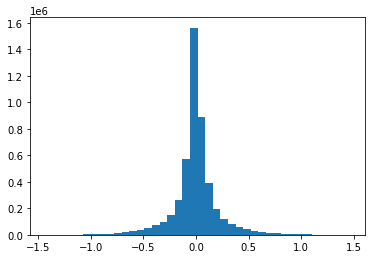

In [33]:
plt.hist(all_headings.flatten(), bins=40)[2]

In [34]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.02778026, 0.03218161, 0.03651281, 0.04084539, 0.04517802,
       0.04950557, 0.05381515, 0.05811042, 0.06239272, 0.06665814,
       0.07090694, 0.07512915, 0.07932317, 0.08349539, 0.0876414 ,
       0.09175901, 0.09584497, 0.09990101, 0.10392854, 0.10783181,
       0.14482898, 0.17908658, 0.20925419, 0.23513526, 0.2569718 ,
       0.27518374, 0.2899503 , 0.30144635, 0.3099912 , 0.31439582],
      dtype=float32)

In [35]:
mean_headings[-1] / mean_headings[0]

11.317239

In [36]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01740946, 0.01918074, 0.02105349, 0.02299186, 0.0249743 ,
       0.02698883, 0.02902551, 0.03107652, 0.03313848, 0.03520699,
       0.03727951, 0.03935436, 0.04142859, 0.04350135, 0.04557145,
       0.0476382 , 0.04970031, 0.05175627, 0.05380573, 0.0558479 ,
       0.07575028, 0.09447048, 0.11180545, 0.12760144, 0.14179723,
       0.1544392 , 0.16562052, 0.17545903, 0.18403798, 0.19141401],
      dtype=float32)

In [37]:
mean_angles[-1] / mean_angles[0]

10.99483

In [38]:
mean_angles[0] / .015

1.1606304595867794

<BarContainer object of 40 artists>

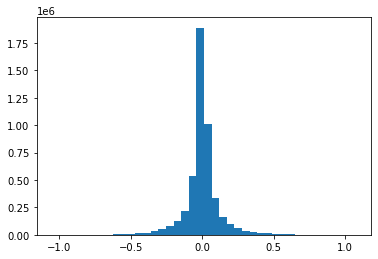

In [39]:
plt.hist(all_wp_angles.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

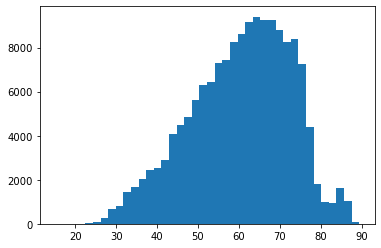

In [40]:
# speed
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

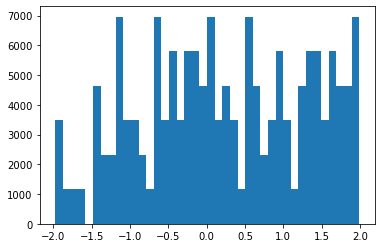

In [41]:
# pitch
plt.hist(all_aux[:,:,0].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

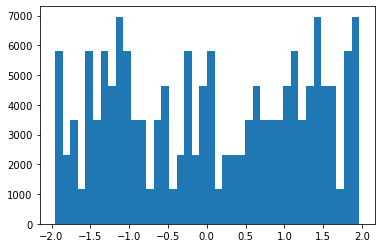

In [42]:
# yaw
plt.hist(all_aux[:,:,1].flatten(), bins=40)[2]